This Notebook mainly shows how to export the top 10 IMA-Approved Minerals in a specified country(e.g. Canada).

In [1]:
#install.packages("remotes")
#remotes::install_github("quexiang/OpenMindat")
#install.packages("dplyr")
#install.packages("ggplot2")

In [2]:
library("OpenMindat")
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
mindat_connection("321e35e57066ccb129a9d9af7ffe1958",base_url = "147.135.28.115")

In [4]:
gl<- localities_list_country("Canada",expand = "~all")

List of 3
 $ next    : chr "https://api.mindat.org/localities/?country=Canada&cursor=cD0yMjgyMQ%3D%3D&expand=~all&id__in=&page_size=800"
 $ previous: NULL
 $ results :List of 800
  ..$ :List of 38
  .. ..$ id                 : int 466
  .. ..$ longid             : chr "1:2:466:5"
  .. ..$ guid               : chr "301b1faa-24c5-4aac-81f7-8f8c24180ae1"
  .. ..$ txt                : chr "Londonderry mines (Acadia mines), Colchester Co., Nova Scotia, Canada"
  .. ..$ revtxtd            : chr "Canada, Nova Scotia, Colchester Co., Londonderry mines (Acadia mines)"
  .. ..$ description_short  : chr "Several mines operated in the area around this town including the East Mines, Old Mountain Mine, and West Mines"| __truncated__
  .. ..$ latitude           : num 45.5
  .. ..$ longitude          : num -63.6
  .. ..$ langtxt            : chr ""
  .. ..$ dateadd            : chr "1980-01-01 00:00:00"
  .. ..$ datemodify         : chr "2019-11-16 01:00:49"
  .. ..$ elements           : chr "-Ca-Fe-O

In [5]:
kv_set<-data.frame(mineral_id =numeric(),cnt = numeric())
for (cur_loc in gl$locentries){
  cur_loc_list<- as.numeric(unlist(cur_loc))
  for (min_id in cur_loc_list) {
    if (min_id %in% kv_set$mineral_id){
      kv_set$cnt[kv_set$mineral_id == min_id]<- kv_set$cnt[kv_set$mineral_id == min_id] + 1
    }
    else{
      df_append<- data.frame(mineral_id = min_id, cnt=1)
      kv_set <- rbind(kv_set,df_append)
    }
  }
}
sorted_kv_desc<- arrange(kv_set,desc(cnt))

In [6]:
getmineral <- function(mid){
  tryCatch({
    ree <- minerals_ima_retrieve(id = mid)
    ree %>% filter(ima_status == "APPROVED")
    ree<- ree[c("id","name")]
    distinct(ree)
  },warning =function(war){
    #cat("warning！",war,"\n")
    #print(sprintf("%d warning!",mid))
    data.frame()
  },error = function(err){
    #cat("error!",err,"\n")
    print(sprintf("%d is not a valid mineral id, wihch may be a geomaterial id.",mid))
    data.frame()
  }
  )
}

In [7]:
top10 <- 10
df_minerals<- data.frame()
for (sikv in sorted_kv_desc$mineral_id){
  if (nrow(df_minerals) < top10){
    print(sikv)
    df_tmp<- getmineral(sikv)
    if (0 != length(df_tmp)){
      cnt<- c(sorted_kv_desc$cnt[sorted_kv_desc$mineral_id == sikv])
      df_tmp$name <- toString(df_tmp$name)
      df_tmp<-cbind(df_tmp,cnt)
      df_minerals<- rbind(df_minerals,df_tmp)
    }
  }
}

[1] 3337
List of 148
 $ id                    : int 3337
 $ longid                : chr "1:1:3337:0"
 $ guid                  : chr "4ca61d6f-75f8-4208-8fb2-3b0eecbcd8f0"
 $ name                  : chr "Quartz"
 $ updttime              : chr "2025-01-15 16:37:30"
 $ mindat_formula        : chr "SiO<sub>2</sub>"
 $ mindat_formula_note   : chr ""
 $ ima_formula           : chr "SiO<sub>2</sub>"
 $ ima_status            :List of 2
  ..$ : chr "APPROVED"
  ..$ : chr "GRANDFATHERED"
 $ ima_notes             : list()
 $ varietyof             : int 0
 $ synid                 : int 0
 $ polytypeof            : int 0
 $ groupid               : int 10916
 $ entrytype             : int 0
 $ entrytype_text        : chr "mineral"
 $ description_short     : chr "Quartz is one of the most common minerals found in the Earth's crust. If pure, quartz forms colorless, transpar"| __truncated__
 $ impurities            : chr "H, Al, Li, Fe, Ti, Na, Mg, Ge, etc"
 $ elements              :List of 2
  ..$ : c

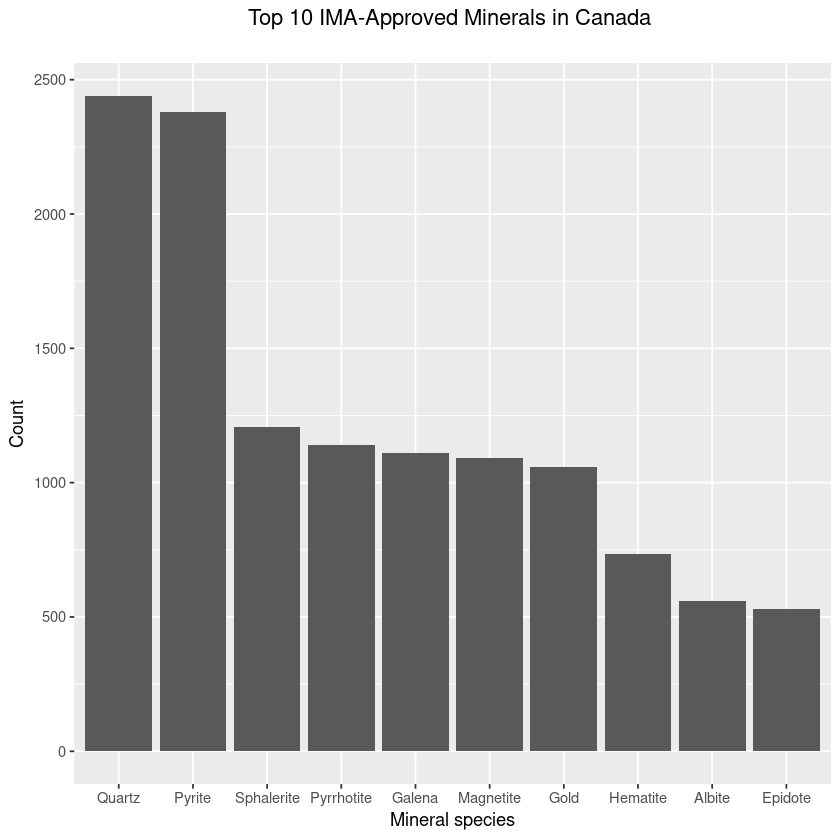

In [8]:
p <- ggplot(df_minerals,aes(reorder(name,-cnt),cnt))
p+geom_bar(stat = 'identity')+ggtitle("Top 10 IMA-Approved Minerals in Canada \n")+ xlab("Mineral species")+ ylab("Count")+theme(plot.title = element_text(hjust = 0.5))